## Import

In [6]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.metrics import pairwise_distances

from scipy.spatial.distance import cdist 

np.set_printoptions(suppress=True)

In [7]:
from sklearn.utils.extmath import row_norms, safe_sparse_dot, stable_cumsum
from sklearn.utils import check_random_state
from sklearn.utils import check_array
from sklearn.metrics.pairwise import euclidean_distances as _euclidean_distances
from sklearn.cluster import KMeans
import scipy.sparse as sp

## POCS-based Clustering Functions

In [8]:
def _kmpp(X, n_clusters, x_squared_norms, random_state, n_local_trials=None):

    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly and track index of point
    center_id = random_state.randint(n_samples)
    indices = np.full(n_clusters, -1, dtype=int)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]
    indices[0] = center_id

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = _euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms, squared=True
    )
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.uniform(size=n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq), rand_vals)
        # XXX: numerical imprecision can result in a candidate_id out of range
        np.clip(candidate_ids, None, closest_dist_sq.size - 1, out=candidate_ids)

        # Compute distances to center candidates
        distance_to_candidates = _euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True
        )

        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates, out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=1)

        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]
        indices[c] = best_candidate

    return centers, indices


def kmpp_initializer(X, n_clusters, x_squared_norms=None, random_state=None, n_local_trials=None):

    # Check data
    check_array(X, accept_sparse="csr", dtype=[np.float64, np.float32])

    if X.shape[0] < n_clusters:
        raise ValueError(
            f"n_samples={X.shape[0]} should be >= n_clusters={n_clusters}."
        )

    # Check parameters
    if x_squared_norms is None:
        x_squared_norms = row_norms(X, squared=True)
    else:
        x_squared_norms = check_array(x_squared_norms, dtype=X.dtype, ensure_2d=False)

    if x_squared_norms.shape[0] != X.shape[0]:
        raise ValueError(
            f"The length of x_squared_norms {x_squared_norms.shape[0]} should "
            f"be equal to the length of n_samples {X.shape[0]}."
        )

    if n_local_trials is not None and n_local_trials < 1:
        raise ValueError(
            f"n_local_trials is set to {n_local_trials} but should be an "
            "integer value greater than zero."
        )

    random_state = check_random_state(random_state)

    # Call private k-means++
    centers, indices = _kmpp(
        X, n_clusters, x_squared_norms, random_state, n_local_trials
    )

    return centers, indices

In [25]:
def pocs_clustering(X, n_clusters, n_iterations):
    
    # Initialize prototypes   
    current_prototypes, _ = kmpp_initializer(X, n_clusters)
    
    # Finding the distance from prototypes to all the data points
    distances = cdist(X, current_prototypes ,'euclidean') # Step 2

    # Assign data points to nearest prototypes
    labels = np.array([np.argmin(i) for i in distances]) # Step 3
    temp_labels = labels.copy()

    for ite in range(n_iterations):

        updated_prototypes = []

        for idx in range(n_clusters):

            # Get data members of a cluster
            cluster_idx_members = X[labels==idx]    

            # Compute weights of importance
            dists = cdist([current_prototypes[idx]], cluster_idx_members ,'euclidean')
            sum_dist = np.sum(dists)
            importances = dists/(sum_dist + 1e-5)         # '1e-5' to avoid dividing by zero
            importances = np.transpose(importances)

            pre_prototypes = current_prototypes[idx].copy()  
            temp_updated_prototypes = current_prototypes[idx].copy()

            moment = importances*(cluster_idx_members - pre_prototypes)
            delta = np.sum(moment, axis=0)
            
            # Update prototypes
            temp_updated_prototypes += delta
            updated_prototypes.append(temp_updated_prototypes)

        current_prototypes = np.array(updated_prototypes)

        # Finding the distance from prototypes to all the data points
        distances = cdist(X, current_prototypes ,'euclidean')

        # Re-assign data points to nearest prototypes
        labels = np.array([np.argmin(i) for i in distances])

        # Check convergence criterion
        difference = np.sum(np.abs(temp_labels-labels))

        if difference == 0:   # converged!
            # print(f'Converged after {ite} iterations!')
            break

        else:
            temp_labels = labels.copy()
            
    return current_prototypes, labels

## Generate Data & Test

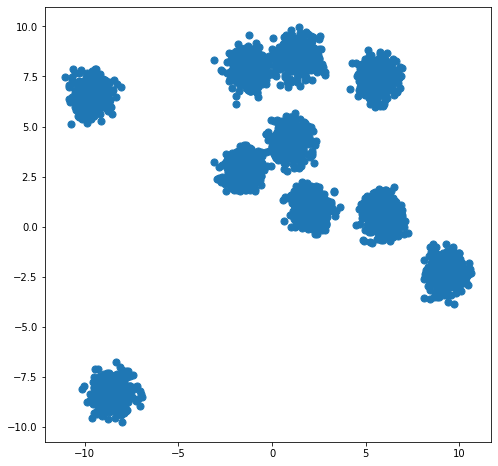

In [22]:
num_clusters = 10

X, y = make_blobs(n_samples=5000, centers=num_clusters, cluster_std=0.5, random_state=0)

plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

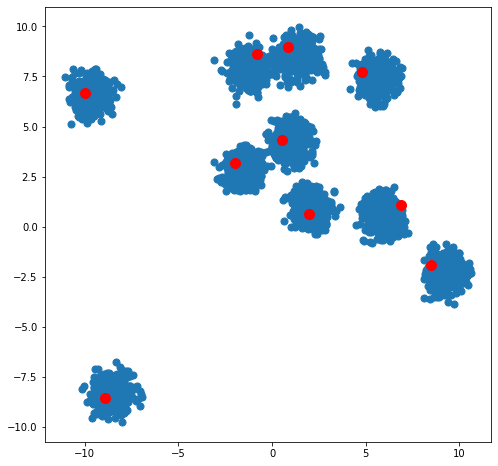

In [23]:
candidates, _ = kmpp_initializer(X, num_clusters)
# print(candidates)
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.scatter(candidates[:, 0], candidates[:, 1], c='red',s=100)
plt.show()

0.04186058044433594


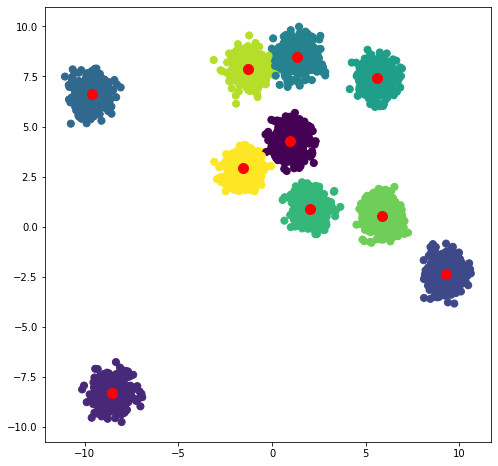

In [39]:
# POSC-based Clustering Algorithm Demo

# num_clusters = 6
start_time = time.time()
centroids, labels = pocs_clustering(X, num_clusters, 100)
end_time = time.time()
proc_time = end_time - start_time
print(proc_time)

# Track results
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=labels,s=50, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], s=100, c='red')
plt.show()

0.059329986572265625


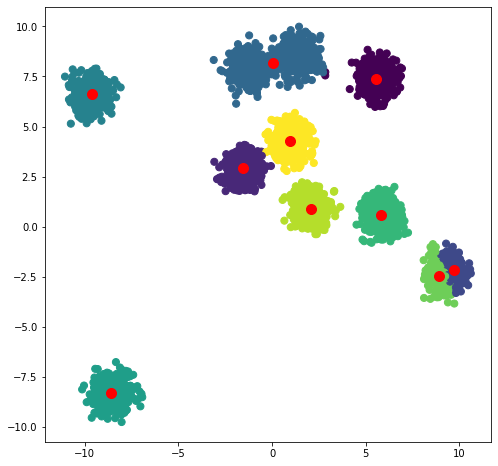

In [40]:
# K-Means Clustering Algorithm

start_time = time.time()

# K-Means
kmeans = KMeans(n_clusters=num_clusters, init='random').fit(X)
labels_kmeans = kmeans.labels_
centers_kmeans = kmeans.cluster_centers_

end_time = time.time()
proc_time = end_time - start_time
print(proc_time)

# Track results
plt.figure(figsize=(8,8))
plt.scatter(X[:, 0], X[:, 1], c=labels_kmeans,s=50, cmap='viridis')
plt.scatter(centers_kmeans[:, 0], centers_kmeans[:, 1], s=100, c='red')
plt.show()